# Substitute Word Generation

=========== Project Code for CMT 318 Portfolio Assessment ==========

Module : Computational Linguistics

Code: 318

Name: Shreyas Ramachandran

Student ID: 24001871

==============================================================

This notebook features a BERT model trained to generate semantically simpler substitute words for a given target word in a sentence, using the BenchLS dataset. It consists of two parts.

## Part 1. Substitution Generation
For Substiution generation we train a BERT model using the BenchLS dataset to provide simpler substitutes for target words in a sentence and evaluate the model's performance on the TSAR-2022 dataset.

## Part 2. Lexical Simplification Demonstration
Using the above trained BERT model and the trained BERT model for CWI, we demonstrate lexical simplification for an input sentence and target word where the pipeline returns the predicted complexity of the target word and a list of substitutes, ranked by their semantic similarity

#### IMPORTANT: All trained model parameters and files are loaded from my google drive. Please modify the paths accordingly before executing these cells.

#### Run train functions to obtain the model parameters. All dataset files are available in the code zip file. Refer the ReadMe file for more information on the dataset files

## Install Dependencies

In [1]:
# Install required libraries
!pip install transformers torch datasets scipy pandas numpy evaluate tqdm wordcloud matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Part 1: Substitute Generation

### Section 1: Load the BenchLS dataset and Tokenize it

In [6]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertTokenizerFast, BertForMaskedLM, RobertaTokenizerFast, RobertaForMaskedLM
from transformers import Trainer, TrainingArguments
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the dataset (assuming a tab-separated format like BenchLS)
def load_benchls_dataset(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            fields = line.strip().split('\t')
            if len(fields) < 4:
                continue
            sentence = fields[0]
            target = fields[1]
            position = int(fields[2])
            candidates = [sub.split(':')[1] for sub in fields[3:] if ':' in sub]
            data.append({'sentence': sentence, 'target': target, 'position': position, 'candidates': candidates})
    return pd.DataFrame(data)

# (Update with correct dataset file path)
benchls_df = load_benchls_dataset('/content/BenchLS.txt')

# Define SubstitutionDataset class with offset_mapping for robust tokenization
class SubstitutionDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        sentence = row['sentence']
        target = row['target']
        position = row['position']

        # Tokenize with offset mapping to align tokens with original text
        encoding = self.tokenizer(sentence, return_offsets_mapping=True, padding='max_length',
                                 max_length=self.max_length, truncation=True)
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        offset_mapping = encoding['offset_mapping']

        # Find character positions of the target word using the position
        words = sentence.split()
        if position >= len(words):
            raise ValueError(f"Position {position} out of range for sentence: '{sentence}'")
        target_word = words[position]
        if target_word.lower() != target.lower():
            raise ValueError(f"Target word '{target}' does not match word at position {position}: '{target_word}'")

        # Calculate character start and end of the target word
        target_start = sentence.find(target_word)
        target_end = target_start + len(target_word)

        # Identify token indices corresponding to the target word
        target_token_indices = []
        for i, (start, end) in enumerate(offset_mapping):
            # Include tokens that overlap with the target word's character span
            if (start < target_end and end > target_start) and start != end:  # Exclude special tokens with zero span
                target_token_indices.append(i)

        if not target_token_indices:
            raise ValueError(f"No tokens found for target word '{target_word}' in sentence: '{sentence}'")

        # Create labels: -100 for non-masked tokens, original token_id for masked tokens
        labels = [-100] * len(input_ids)
        for idx in target_token_indices:
            labels[idx] = input_ids[idx]  # Set label to original token ID
            input_ids[idx] = self.tokenizer.mask_token_id  # Mask the token

        return {
            'input_ids': torch.tensor(input_ids),
            'attention_mask': torch.tensor(attention_mask),
            'labels': torch.tensor(labels)
        }

# Training function
def train_model(model, tokenizer, train_dataset, model_name):
    training_args = TrainingArguments(
        output_dir=f'./{model_name}_results',
        num_train_epochs=10,
        per_device_train_batch_size=16,
        save_steps=10_000,
        save_total_limit=2,
        logging_dir=f'./{model_name}_logs',
        logging_steps=100,
        report_to='none'
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
    )

    trainer.train()

    # Trained model save path: (Update with correct path)
    model.save_pretrained(f'/content/{model_name}')
    tokenizer.save_pretrained(f'/content/{model_name}')

### Section 2: BenchLS dataset Analysis

In [3]:
import pandas as pd

def analyze_benchls(file_path):
    """
    Performs descriptive statistics on the BenchLS dataset.

    Args:
        file_path (str): The path to the BenchLS dataset file.

    Returns:
        None. Prints the dataset size and the first 5 examples.
    """
    try:
        print(f"Dataset size: {len(benchls_df)} rows")
        print("\nFirst 5 examples:")
        print(benchls_df.head())
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage (replace with the actual file path)
benchls_path = '/content/BenchLS.txt'
analyze_benchls(benchls_path)

Dataset size: 929 rows

First 5 examples:
                                            sentence     target  position  \
0  in March 1992 , Linux version 0.95 was the fir...     pieces        35   
1  much of the water carried by these streams is ...   diverted         9   
2  Harry also becomes the worthy possessor of the...  possessor         5   
3  Escapologists escape from handcuffs , straitja...     perils        24   
4  the storm continued , crossing the Outer Banks...   retained        13   

                                          candidates  
0  [parts, bits, components, information, element...  
1  [redirected, rerouted, changed, moved, separat...  
2    [owner, holder, keeper, buyer, master, teacher]  
3  [dangers, hazards, situations, danger, problem...  
4                 [kept, held, maintained, regained]  


### Section 3: Model Training

If you do not want to run the training code for this model, then you can download the trained model parameters from the given google drive links in README.md file

If you are uploading the saved model, then you can skip executing the below training cell

In [ ]:
# BERT Training
print("Training BERT Model")
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
bert_dataset = SubstitutionDataset(benchls_df, bert_tokenizer)
bert_model = BertForMaskedLM.from_pretrained('bert-base-uncased').to(device)
train_model(bert_model, bert_tokenizer, bert_dataset, 'ls_model_bert')

Training BERT Model


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Step,Training Loss
100,2.485400
200,0.298300
300,0.168300
400,0.019800
500,0.013800


### Section 4: Example of Substitution Generation

For running this section, you need the trained Substitution Generation BERT model. If you have not run the training code for this model, then you can download the saved model from the below google drive link and upload them to the session storage (modify the paths below accordingly)

    - LS BERT model: https://drive.google.com/drive/folders/1-1XxFEUDb_W0KDc5O9IX_HICAMrcP0QG?usp=sharing

In [7]:
# Section 4: Substitution Generation
import torch

# Initialize BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load the trained BERT MLM model
from transformers import BertForMaskedLM

# Load the saved model (update with correct cwi_model_bert path)
bert_mlm_model = BertForMaskedLM.from_pretrained('/content/ls_model_bert')
bert_mlm_model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')) # Move to appropriate device

def generate_substitutions(sentence, target, model, tokenizer, top_k=10):
    """
    Generate substitutions for the target word in the sentence.

    Parameters:
    sentence (str): Input sentence.
    target (str): Target word to replace.
    model (BertForMaskedLM): Trained MLM model.
    tokenizer (BertTokenizer): Tokenizer.
    top_k (int): Number of top predictions to return.

    Returns:
    list: List of top-k substitution words.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Define device
    inputs = tokenizer(sentence, return_tensors='pt')
    input_ids = inputs['input_ids'][0].to(device)

    target_tokens = tokenizer.tokenize(target)
    if len(target_tokens) != 1:
        return []
    target_token_id = tokenizer.convert_tokens_to_ids(target_tokens[0])
    target_idx = (input_ids == target_token_id).nonzero(as_tuple=True)[0]
    if len(target_idx) == 0:
        return []
    target_idx = target_idx[0].item()

    input_ids[target_idx] = tokenizer.mask_token_id

    with torch.no_grad():
        outputs = model(input_ids.unsqueeze(0))
        predictions = outputs.logits[0, target_idx]

    top_k_ids = torch.topk(predictions, top_k).indices
    substitutions = [tokenizer.decode([id]) for id in top_k_ids]
    return substitutions

# Example substitution generation for BERT Model
sentence = "Lebanon is sharply split along sectarian lines, with 18 religious sects."
target = "along"
substitutions = generate_substitutions(sentence, target, bert_mlm_model, bert_tokenizer)
print(f"BERT Substitutions for '{target}': {substitutions}")
print("\n")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

BERT Substitutions for 'along': ['along', 'on', 'across', 'in', 'by', 'upon', 'between', 'into', 'among', 'down']




### Section 5: Evaluation with TSAR-2022 dataset

In [8]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import torch


# Load the sentence transformer model for semantic similarity
similarity_model = SentenceTransformer('all-MiniLM-L6-v2')

# Randomly sample 10 examples
sample_df = benchls_df.sample(n=10, random_state=42)

# Perform descriptive analysis
print("Descriptive Analysis of BenchLS Dataset")
print("=" * 50)
print("Displaying 10 Random Examples with Target Word and Substitutions")
print("Including Semantic Similarities between Target and Substitutions")
print("=" * 50)

for idx, row in sample_df.iterrows():
    sentence = row['sentence']
    target = row['target']
    substitutions = row['candidates']

    # Compute semantic similarities
    similarities = []
    if substitutions:
        # Get embeddings for target and substitutions
        target_embedding = similarity_model.encode(target.lower(), convert_to_tensor=True)
        sub_embeddings = similarity_model.encode([sub.lower() for sub in substitutions], convert_to_tensor=True)

        # Compute cosine similarities
        cos_sim = util.cos_sim(target_embedding, sub_embeddings)[0]
        similarities = [(sub, cos_sim[i].item()) for i, sub in enumerate(substitutions)]
        # Sort by similarity (descending)
        similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

    # Print example
    print(f"\nExample {idx + 1}:")
    print(f"Sentence: {sentence}")
    print(f"Target Word: {target}")
    print("Substitutions and Semantic Similarities:")
    if similarities:
        for sub, sim in similarities:
            print(f"  - {sub}: {sim:.4f}")
    else:
        print("  - No substitutions available")
    print("-" * 50)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Descriptive Analysis of BenchLS Dataset
Displaying 10 Random Examples with Target Word and Substitutions
Including Semantic Similarities between Target and Substitutions

Example 757:
Sentence: now here he is , gowned and on a gurney , forced to endure a medical procedure all because of some soup .
Target Word: endure
Substitutions and Semantic Similarities:
  - suffer: 0.5821
  - undergo: 0.5069
  - have: 0.2704
--------------------------------------------------

Example 670:
Sentence: the only detectable effect was psychological stress during and shortly after the accident .
Target Word: shortly
Substitutions and Semantic Similarities:
  - soon: 0.8122
  - immediately: 0.6885
  - briefly: 0.5571
  - quickly: 0.5485
  - just: 0.3584
--------------------------------------------------

Example 31:
Sentence: Alfonso drops the marriage contract in front of the officers , and , when they read it , they become enraged .
Target Word: enraged
Substitutions and Semantic Similarities:
  - anger

For running this section, you need the trained Substitution Generation BERT model. If you have not run the training code for this model, then you can download the saved model from the below google drive link and upload them to the session storage (modify the paths below accordingly)

    - LS BERT model: https://drive.google.com/drive/folders/1-1XxFEUDb_W0KDc5O9IX_HICAMrcP0QG?usp=sharing

Accuracy (at least one match in top-10): 0.5925
Average maximum similarity: 0.6524


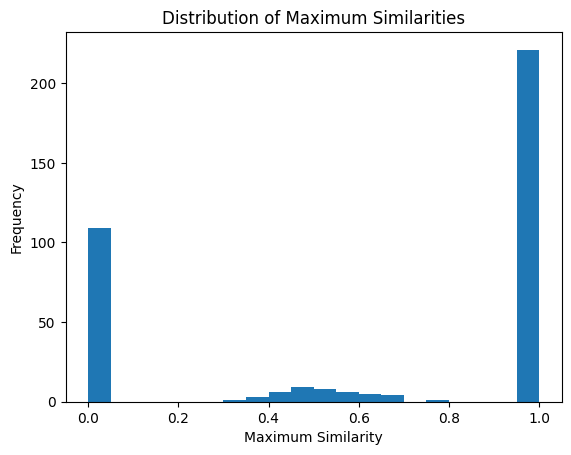

In [9]:
import pandas as pd
import torch
from transformers import BertForMaskedLM, BertTokenizer
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the trained substitution generation model and tokenizer (Update with actual model paths)
model_path = '/content/ls_model_bert'
mlm_model = BertForMaskedLM.from_pretrained(model_path).to(device)
tokenizer = BertTokenizer.from_pretrained(model_path)

# Load the sentence transformer model for semantic similarity
similarity_model = SentenceTransformer('all-MiniLM-L6-v2')

# Load the TSAR dataset
tsar_url = "/content/tsar2022_en_test_gold.tsv"
tsar_df = pd.read_csv(tsar_url, sep='\t', header=None)
tsar_df['sentence'] = tsar_df[0]
tsar_df['target'] = tsar_df[1]
tsar_df['gold_substitutes'] = tsar_df.iloc[:, 2:].apply(lambda row: [x.strip() for x in row if pd.notna(x)], axis=1)
tsar_df = tsar_df[['sentence', 'target', 'gold_substitutes']]

# Function to generate substitutions
def generate_substitutions(sentence, target, model, tokenizer, top_k=10):
    inputs = tokenizer(sentence, return_tensors='pt')
    input_ids = inputs['input_ids'][0].to(device)

    target_tokens = tokenizer.tokenize(target)
    if len(target_tokens) != 1:
        return []
    target_token_id = tokenizer.convert_tokens_to_ids(target_tokens[0])
    target_idx = (input_ids == target_token_id).nonzero(as_tuple=True)[0]
    if len(target_idx) == 0:
        return []
    target_idx = target_idx[0].item()

    input_ids[target_idx] = tokenizer.mask_token_id

    with torch.no_grad():
        outputs = model(input_ids.unsqueeze(0))
        predictions = outputs.logits[0, target_idx]

    top_k_ids = torch.topk(predictions, top_k).indices
    substitutions = [tokenizer.decode([id]).strip() for id in top_k_ids]
    return substitutions

# Evaluate on TSAR dataset
matches = []
max_similarities = []
for _, row in tsar_df.iterrows():
    sentence = row['sentence']
    target = row['target']
    gold = row['gold_substitutes']
    predictions = generate_substitutions(sentence, target, mlm_model, tokenizer, top_k=10)

    # Check if any prediction matches gold substitutes (case-insensitive)
    match = any(pred.lower() in [g.lower() for g in gold] for pred in predictions)
    matches.append(match)

    # Compute maximum similarity
    if predictions and gold:
        # Compute embeddings for predicted and gold substitutes
        pred_embeddings = similarity_model.encode([pred.lower() for pred in predictions], convert_to_tensor=True, device=device)
        gold_embeddings = similarity_model.encode([g.lower() for g in gold], convert_to_tensor=True, device=device)

        # Compute pairwise cosine similarities
        similarities = util.pytorch_cos_sim(pred_embeddings, gold_embeddings)

        # Find the maximum similarity
        max_sim = similarities.max().item()
    else:
        max_sim = 0
    max_similarities.append(max_sim)

# Compute accuracy
accuracy = sum(matches) / len(matches)
print(f"Accuracy (at least one match in top-10): {accuracy:.4f}")

# Compute average maximum similarity
avg_max_sim = sum(max_similarities) / len(max_similarities)
print(f"Average maximum similarity: {avg_max_sim:.4f}")

# Plot histogram of maximum similarities
plt.hist(max_similarities, bins=20)
plt.xlabel('Maximum Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Maximum Similarities')
plt.savefig('similarity_distribution.png')
plt.show()
plt.close()

In [10]:
import pandas as pd
from sentence_transformers import util

# Assuming mlm_model, tokenizer, similarity_model, tsar_df, and device are already defined
# mlm_model: Trained BertForMaskedLM
# tokenizer: BertTokenizer
# similarity_model: SentenceTransformer('all-MiniLM-L6-v2')
# tsar_df: DataFrame with TSAR dataset
# device: torch.device('cuda' or 'cpu')

# Randomly sample 10 examples from TSAR dataset
sample_tsar_df = tsar_df.sample(n=10, random_state=42)

print("\nTSAR Dataset Prediction and Comparison")
print("=" * 50)
print("Displaying Predictions for 10 Random TSAR Examples")
print("Including Semantic Similarities to Gold Substitutions")
print("=" * 50)

for idx, row in sample_tsar_df.iterrows():
    sentence = row['sentence']
    target = row['target']
    gold_substitutes = row['gold_substitutes']

    # Generate predictions (top-10 substitutions)
    predicted_substitutes = generate_substitutions(sentence, target, mlm_model, tokenizer, top_k=10)

    # Compute semantic similarities between predicted and gold substitutes
    similarities = []
    if predicted_substitutes and gold_substitutes and any(gold_substitutes):  # Ensure there are valid gold substitutes
        # Get embeddings
        pred_embeddings = similarity_model.encode([pred.lower() for pred in predicted_substitutes], convert_to_tensor=True, device=device)
        gold_embeddings = similarity_model.encode([g.lower() for g in gold_substitutes if g], convert_to_tensor=True, device=device)

        # Compute pairwise cosine similarities
        cos_sim = util.pytorch_cos_sim(pred_embeddings, gold_embeddings)

        # For each predicted substitute, find the maximum similarity to any gold substitute
        max_sims = cos_sim.max(dim=1).values
        similarities = [(pred, max_sims[i].item()) for i, pred in enumerate(predicted_substitutes)]
        # Sort by similarity (descending)
        similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

    # Print example
    print(f"\nExample {idx + 1}:")
    print(f"Sentence: {sentence}")
    print(f"Target Word: {target}")
    print("Predicted Substitutions (with Max Semantic Similarity to Gold):")
    if similarities:
        for pred, sim in similarities:
            print(f"  - {pred}: {sim:.4f}")
    else:
        print("  - No valid predictions or gold substitutes available")
    print("Gold Substitutions:")
    if gold_substitutes and any(gold_substitutes):
        for gold in gold_substitutes:
            if gold:  # Skip empty strings
                print(f"  - {gold}")
    else:
        print("  - No gold substitutes available")
    print("-" * 50)


TSAR Dataset Prediction and Comparison
Displaying Predictions for 10 Random TSAR Examples
Including Semantic Similarities to Gold Substitutions

Example 328:
Sentence: Two Chinese marine surveillance ships are in this area fulfilling the duties of safeguarding Chinese maritime rights and interests, it said in a statement.
Target Word: safeguarding
Predicted Substitutions (with Max Semantic Similarity to Gold):
  - No valid predictions or gold substitutes available
Gold Substitutions:
  - protecting
  - protecting
  - protecting
  - protecting
  - protecting
  - protecting
  - protecting
  - protecting
  - protecting
  - protecting
  - protecting
  - protecting
  - protecting
  - protecting
  - protecting
  - protecting
  - protecting
  - protecting
  - protecting
  - protecting
  - protecting
  - defending
  - patrolling
  - preserving
  - shielding
  - Two Chinese marine surveillance ships are in this area fulfilling the duties of safeguarding Chinese maritime rights and interests, i

## Part 2: Lexical Simplification Demonstration

In this part, we demonstrate Lexical simplification of a target word in a sentence. For a given input sentence and target word, we use the trained cwi model and ls model to predict the complexity of the target word, and provide a list of substitutes for the target word (the model returns [UNK] if it is unable to provide a substitute). These substitutes are ranked by their semantic similarity (descending) using the 'all-MiniLM-L6-v2' pretrained model.

For running this section, you need the trained CWI BERT model and the trained Substitution generation BERT model. If you have not run the training code for these models, then you can download the saved model from the below google drive links and upload them to the session storage (modify the paths below accordingly)

    - CWI BERT model: https://drive.google.com/drive/folders/1lJvZMnqxa8xysjkETOW0hervhYLhncso?usp=sharing
    - LS BERT model: https://drive.google.com/drive/folders/1-1XxFEUDb_W0KDc5O9IX_HICAMrcP0QG?usp=sharing

In [ ]:
import torch
from transformers import BertTokenizer, BertForTokenClassification, BertForMaskedLM
from sentence_transformers import SentenceTransformer, util

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load models and tokenizer (Update with actual model paths)
complexity_model_path = '/content/cwi_model_bert'
substitute_model_path = '/content/ls_model_bert'
tokenizer = BertTokenizer.from_pretrained(complexity_model_path)
complexity_model = BertForTokenClassification.from_pretrained(complexity_model_path).to(device)
substitute_model = BertForMaskedLM.from_pretrained(substitute_model_path).to(device)
similarity_model = SentenceTransformer('all-MiniLM-L6-v2').to(device)

def predict_complexity(sentence, target, model, tokenizer, device):
    model.eval()
    inputs = tokenizer(sentence, return_tensors='pt', padding='max_length', max_length=128, truncation=True)
    tokens = tokenizer.tokenize(sentence)
    target_lower = target.lower()
    target_idx = tokens.index(target_lower) if target_lower in tokens else None
    if target_idx is None:
        raise ValueError(f"Target word '{target}' not found in sentence.")

    with torch.no_grad():
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = model(**inputs).logits
        complexity = outputs[0, target_idx, 0].item()  # Assuming regression head
    return complexity

def generate_substitutes(sentence, target, model, tokenizer, device, top_k=10):
    inputs = tokenizer(sentence, return_tensors='pt')
    input_ids = inputs['input_ids'][0].to(device)

    target_tokens = tokenizer.tokenize(target)
    if len(target_tokens) != 1:
        raise ValueError(f"Target word '{target}' is not a single token.")
    target_token_id = tokenizer.convert_tokens_to_ids(target_tokens[0])
    target_idx = (input_ids == target_token_id).nonzero(as_tuple=True)[0]
    if len(target_idx) == 0:
        raise ValueError(f"Target token '{target}' not found in sentence.")
    target_idx = target_idx[0].item()

    input_ids[target_idx] = tokenizer.mask_token_id

    with torch.no_grad():
        outputs = model(input_ids.unsqueeze(0))
        predictions = outputs.logits[0, target_idx]

    top_k_ids = torch.topk(predictions, top_k).indices
    substitutes = [tokenizer.decode([id]).strip() for id in top_k_ids]
    return substitutes

def compute_similarity(target, substitutes, similarity_model, device):
    if not substitutes:
        return []
    # Encode target and substitutes
    target_embedding = similarity_model.encode(target.lower(), convert_to_tensor=True, device=device)
    substitute_embeddings = similarity_model.encode([sub.lower() for sub in substitutes], convert_to_tensor=True, device=device)

    # Compute cosine similarities
    cos_sim = util.pytorch_cos_sim(target_embedding, substitute_embeddings).squeeze(0)

    # Pair substitutes with their similarity scores
    similarities = [(sub, sim.item()) for sub, sim in zip(substitutes, cos_sim)]
    # Sort by similarity descending
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return similarities

def pipeline(sentence, target):
    try:
        complexity = predict_complexity(sentence, target, complexity_model, tokenizer, device)
        substitutes = generate_substitutes(sentence, target, substitute_model, tokenizer, device)
        ranked_substitutes = compute_similarity(target, substitutes, similarity_model, device)

        print(f"Complexity of '{target}': {complexity:.4f}")
        print("Substitute words ranked by semantic similarity:")
        if ranked_substitutes:
            for sub, score in ranked_substitutes:
                print(f"  - {sub}: {score:.4f}")
        else:
            print("  - No substitutes generated.")
    except ValueError as e:
        print(f"Error: {e}")

# Example usage
sentence = "Benson collaborated with artist Jamie McKelvie on a short story within the Image comics collection Four Letter Worlds"
target = "collection"
pipeline(sentence, target)

Complexity of 'collection': 0.0996
Substitute words ranked by semantic similarity:
  - series: 0.4519
  - titled: 0.4071
  - anthology: 0.3698
  - novel: 0.3203
  - comic: 0.2982
  - title: 0.2966
  - imprint: 0.2933
  - miniseries: 0.2731
  - annual: 0.2543
  - story: 0.2249
